In [ ]:
import numpy as np
import random
np.random.seed(1)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

In [ ]:
class GeneticAlgorithm:
    def mutation(self,chromosome,chance):
        index_of_mutated = random.randint(0, len(chromosome) - 1)
        try_to_mutate = random.randint(0, 100)
        if try_to_mutate <= chance:
            if chromosome[index_of_mutated] == 0:
                chromosome[index_of_mutated] = 1
            else:
                chromosome[index_of_mutated] = 0
        return chromosome
    
    def random_chromosome(self,length):
        return np.random.randint(0, 2, length).tolist()
    
    def get_num_of_perc(self,chromosome):
        count = 0
        for i in range(0,len(chromosome)):
            count += (2**i) * chromosome[i]
        return count
    
    def make_new_chromosomes(self,chr1,chr2):
        border = random.randint(1, len(chr2) - 1)
        child1 = []
        child2 = []
        for i in range(0,len(chr2)):
            if i < border:
                child1.append(chr1[i])
                child2.append(chr2[i])
            else:
                child1.append(chr2[i])
                child2.append(chr1[i])
        return child1,child2
    
    def fitness_function(self, fit_1):
        sum_of_good = np.sum(fit_1.history['accuracy'])
        return sum_of_good / len(fit_1.history['accuracy'])
    
    def roulette_wheel_selection(self,scores):
        suma = np.sum(scores)
        procents = [] 
        for i in range(0,len(scores)):
            procents.append(scores[i]/suma)
        arr_of_chance = []
        
        for i in range(0,len(scores)):
            for j in range(0,int(scores[i] * 100)):
                arr_of_chance.append(i)
        
        return random.choice(arr_of_chance)
    
    
    def make_new_popul(self,chromosomes_population,score,chance_mut, X_train,y_train,val_stop,tb,X_test,y_test,n_pop):
        
        new_models_population = []
        new_score = []
        new_chromosomes_population = [] 
        
        for i in range(n_pop):
            new_models_population.append(models.Sequential())
            new_models_population[i].add(layers.InputLayer(input_shape=(8, 8, 1), name='input'))

        for i in range(0,int(n_pop/2)):
            first_index = self.roulette_wheel_selection(score)
            second_index = first_index
            while first_index  == second_index:
                second_index = self.roulette_wheel_selection(score)
                
            child1, child2 = self.make_new_chromosomes(chromosomes_population[first_index],chromosomes_population[second_index])
            
            child1 = self.mutation(child1,chance_mut)
            child2 = self.mutation(child2,chance_mut)

            new_chromosomes_population.append(child1)
            new_chromosomes_population.append(child2)


        for i in range(0,n_pop):
            new_models_population[i].add(layers.Flatten(name='flatten'))
            if self.get_num_of_perc(chromosomes_population[i]) != 0:
                new_models_population[i].add(layers.Dense(self.get_num_of_perc(chromosomes_population[i]), activation='relu', name='hidden'))
            new_models_population[i].add(layers.Dense(10, activation='softmax', name='output'))
            new_models_population[i].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
            fit_1 = new_models_population[i].fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))
            new_score.append(self.fitness_function(fit_1))
        
        return new_chromosomes_population,new_score,new_models_population
    
    
    
    def genetic_algorithm(self,n_gens, n_iter, n_pop, chance_mut, X_train,y_train,val_stop,tb,X_test,y_test):
        
        models_population = []
        chromosomes_population = []
        score = []



        new_models_population = []
        new_score = []
        new_chromosomes_population = [] 
        
        for i in range(n_pop):
            models_population.append(models.Sequential())
            models_population[i].add(layers.InputLayer(input_shape=(8, 8, 1), name='input'))
        print(models_population)

        for i in range(0,n_pop):
            q = self.random_chromosome(n_gens)
            chromosomes_population.append(q)
        print(chromosomes_population)

        for i in range(0,n_pop):
            models_population[i].add(layers.Flatten(name='flatten'))
            if chromosomes_population[i] != 0:
                models_population[i].add(layers.Dense(self.get_num_of_perc(chromosomes_population[i]), activation='relu', name='hidden'))
            models_population[i].add(layers.Dense(10, activation='softmax', name='output'))
            models_population[i].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
            print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            fit_1 = models_population[i].fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))
            score.append(self.fitness_function(fit_1))
        print(models_population)
        print(score)


        print("start population")
        print(chromosomes_population)
        print("start score")
        print(score)
        print()


        for i in range(n_iter):
            new_chromosomes_population,new_score,new_models_population = self.make_new_popul(chromosomes_population,score,chance_mut, X_train,y_train,val_stop,tb,X_test,y_test,n_pop)
            
            print("population " + str(i))
            print(new_chromosomes_population)
            print("population scores " + str(i))
            print(new_score)
            print()
            
            models_population = new_models_population
            chromosomes_population = new_chromosomes_population
            score = new_score

        return models_population, chromosomes_population, score   
        

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
MinMaxScaler(copy=False).fit_transform(X)

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])

In [ ]:
X = X.reshape(X.shape[0], 8, 8, 1).astype('float32')

In [ ]:
y = to_categorical(y)
y.shape[0], y.shape[1], y

(1797, 10, array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32))

In [ ]:
X.dtype, X.shape, X.max(), y.shape

(dtype('float32'), (1797, 8, 8, 1), 1.0, (1797, 10))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=42)

%load_ext tensorboard

val_stop = EarlyStopping(monitor='val_loss', patience=5)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(logdir, histogram_freq=1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1347, 8, 8, 1), (450, 8, 8, 1), (1347, 10), (450, 10))

In [ ]:
gen = GeneticAlgorithm()

In [ ]:
models_population, chromosomes_population, score = gen.genetic_algorithm(6, 10, 6, 10, X_train,y_train,val_stop,tb,X_test,y_test)

[<keras.engine.sequential.Sequential object at 0x7f4173307dd0>, <keras.engine.sequential.Sequential object at 0x7f4173375150>, <keras.engine.sequential.Sequential object at 0x7f4172f9aa90>, <keras.engine.sequential.Sequential object at 0x7f417327a5d0>, <keras.engine.sequential.Sequential object at 0x7f417327a390>, <keras.engine.sequential.Sequential object at 0x7f417327fb50>]
[[1, 1, 0, 0, 1, 1], [1, 1, 1, 0, 0, 1], [0, 1, 1, 0, 0, 1], [0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 1, 0], [0, 0, 1, 1, 1, 1]]
(1347, 8, 8, 1) (450, 8, 8, 1) (1347, 10) (450, 10)
Epoch 1/15
43/43 [==============================] - 1s 10ms/step - loss: 2.0981 - accuracy: 0.3422 - val_loss: 1.8258 - val_accuracy: 0.5933
Epoch 2/15
43/43 [==============================] - 0s 3ms/step - loss: 1.6089 - accuracy: 0.6971 - val_loss: 1.3747 - val_accuracy: 0.7844
Epoch 3/15
43/43 [==============================] - 0s 3ms/step - loss: 1.1926 - accuracy: 0.8337 - val_loss: 1.0141 - val_accuracy: 0.8311
Epoch 4/15
43/43 [=========

In [ ]:
best_model = models_population[np.array(score).argmax(axis=0)] 

In [ ]:
fit_1 = best_model.fit(X_train, y_train, 
                    epochs=15, 
                    # batch_size=32,
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))

Epoch 1/15
43/43 [==============================] - 0s 4ms/step - loss: 0.5086 - accuracy: 0.9169 - val_loss: 0.5198 - val_accuracy: 0.9067
Epoch 2/15
43/43 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.9280 - val_loss: 0.4821 - val_accuracy: 0.9044
Epoch 3/15
43/43 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.9287 - val_loss: 0.4455 - val_accuracy: 0.9200
Epoch 4/15
43/43 [==============================] - 0s 3ms/step - loss: 0.3951 - accuracy: 0.9369 - val_loss: 0.4157 - val_accuracy: 0.9222
Epoch 5/15
43/43 [==============================] - 0s 3ms/step - loss: 0.3671 - accuracy: 0.9332 - val_loss: 0.3938 - val_accuracy: 0.9222
Epoch 6/15
43/43 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.9421 - val_loss: 0.3713 - val_accuracy: 0.9244
Epoch 7/15
43/43 [==============================] - 0s 3ms/step - loss: 0.3193 - accuracy: 0.9421 - val_loss: 0.3505 - val_accuracy: 0.9267
Epoch 8/15
43/43 [==

In [ ]:
y_pred_1 = fit_1.model.predict(X_test)

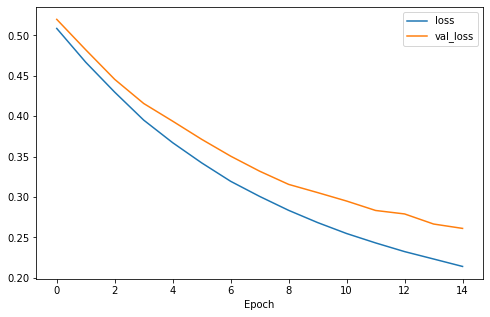

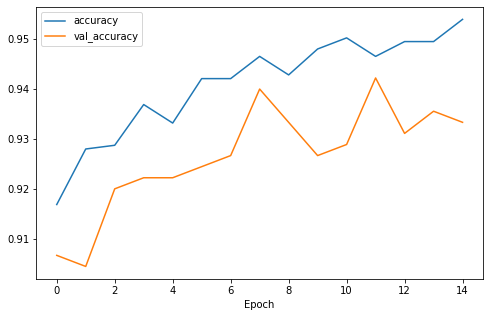

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fit_1.history['loss'], '-', label='loss')
plt.plot(fit_1.history['val_loss'], '-', label='val_loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(fit_1.history['accuracy'], '-', label='accuracy')
plt.plot(fit_1.history['val_accuracy'], '-', label='val_accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

array([[44,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 40,  1,  0,  0,  0,  1,  0,  2,  2],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 40,  0,  0,  0,  0,  4,  1],
       [ 1,  0,  0,  0, 42,  0,  0,  0,  1,  1],
       [ 0,  0,  1,  0,  0, 43,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 45,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 45,  0,  0],
       [ 0,  5,  1,  0,  1,  0,  0,  0, 36,  0],
       [ 0,  0,  0,  2,  0,  1,  0,  0,  1, 41]])

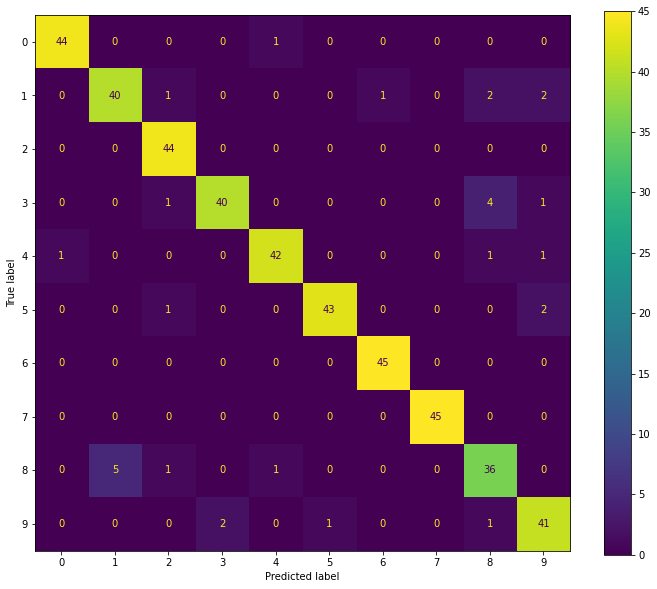

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1))
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(12, 10))
cmp.plot(ax=ax)
cm

In [ ]:
len(y_test)

450

In [ ]:
cm.sum()

450